# We wish to see if PCIAT (Parent Child Internet Addiction Test) scores and responses correlate with Age

In [204]:
# Import all necessary libraries for correlation analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# for statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import shapiro

In [8]:
# Load in data
df_filepath = r"C:\Users\quynh\OneDrive\Documents\DSA 330\Final Project\train (1).csv"
df = pd.read_csv(data_filepath)

In [10]:
print(df.head())

         id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT

## What kind of variables we are working with

* **Basic_Demos-Age**: Numerical (5-22 years old)
* PCIAT
* * **PCIAT-Season**: Categorical (Spring, Summer, Fall, Winter) *not exactly relevant for analysis
  * **PCIAT-PCIAT_01 - PCIAT-PCIAT_20**: Categorical (0,1,2,3,4,5)
  * 0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=Frequently, 4=Often, 5=Always
  * **PCIAT-PCIAT_Total**: Int 

**Target**: PCIAT
**Independent**: Age

## 1. Narrow Data Down

In [29]:
# Group PCIAT questions together for convienence
pciatQ_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
pciatQ_df= df[pciatQ_columns]
print(pciatQ_df)

      PCIAT-PCIAT_01  PCIAT-PCIAT_02  PCIAT-PCIAT_03  PCIAT-PCIAT_04  \
0                5.0             4.0             4.0             0.0   
1                0.0             0.0             0.0             0.0   
2                5.0             2.0             2.0             1.0   
3                4.0             2.0             4.0             0.0   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
3955             3.0             3.0             3.0             2.0   
3956             NaN             NaN             NaN             NaN   
3957             5.0             5.0             3.0             0.0   
3958             2.0             1.0             1.0             1.0   
3959             NaN             NaN             NaN             NaN   

      PCIAT-PCIAT_05  PCIAT-PCIAT_06  PCIAT-PCIAT_07  PCIAT-PCIAT_08  \
0                4.0             0.0             0.0           

## 2. Null Values: Identifying and Handling

In [41]:
# List of columns to check
columns_to_check = ['Basic_Demos-Age', 'PCIAT-PCIAT_Total', 'PCIAT-Season']

# Count of null values
null_counts = df[columns_to_check].isnull().sum()

# Total number of rows in the dataset
total_rows = len(df)

# Calculate percentages of null values
null_percentages = (null_counts / total_rows) * 100

# Combine counts and percentages into a DataFrame for better readability
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage (%)': null_percentages
})

# Print the summary
print(null_summary)

# For PCIAT questions DataFrame
pciat_null_counts = pciatQ_df.isnull().sum()
pciat_null_percentages = (pciat_null_counts / len(pciatQ_df)) * 100

pciat_null_summary = pd.DataFrame({
    'Null Count': pciat_null_counts,
    'Null Percentage (%)': pciat_null_percentages
})

print(pciat_null_summary)

                   Null Count  Null Percentage (%)
Basic_Demos-Age             0             0.000000
PCIAT-PCIAT_Total        1224            30.909091
PCIAT-Season             1224            30.909091
                Null Count  Null Percentage (%)
PCIAT-PCIAT_01        1227            30.984848
PCIAT-PCIAT_02        1226            30.959596
PCIAT-PCIAT_03        1229            31.035354
PCIAT-PCIAT_04        1229            31.035354
PCIAT-PCIAT_05        1231            31.085859
PCIAT-PCIAT_06        1228            31.010101
PCIAT-PCIAT_07        1231            31.085859
PCIAT-PCIAT_08        1230            31.060606
PCIAT-PCIAT_09        1230            31.060606
PCIAT-PCIAT_10        1227            30.984848
PCIAT-PCIAT_11        1226            30.959596
PCIAT-PCIAT_12        1229            31.035354
PCIAT-PCIAT_13        1231            31.085859
PCIAT-PCIAT_14        1228            31.010101
PCIAT-PCIAT_15        1230            31.060606
PCIAT-PCIAT_16        1232  

There is a lot of missing values. We won't remove as it might affect the analysis, so we'll impute
* Replace Nan values with median for Basic Demos Age, PCIAT-PCIAT_Total
* Replace Nan values with mode for PCIAT questions

**We don't want to ruin original df, so we'll work with a copy with imputed data for the analysis**

In [57]:
df_copy = df.copy()

In [61]:
# Verify
print(df_copy.head())

         id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT

### 2a. Impute Categorical Variables

Mode and Median before Imputing

In [135]:
# Loop through all PCIAT question columns
for column in pciatQ_df.columns:
    if not pciatQ_df[column].dropna().mode().empty:  # Check if mode exists
        mode_value = pciatQ_df[column].dropna().mode()[0]  # Compute mode excluding NaN
        print(f"Mode for {column} (excluding NaN): {mode_value}")
    else:
        print(f"No mode found for {column} (excluding NaN).")

Mode for PCIAT-PCIAT_01 (excluding NaN): 2.0
Mode for PCIAT-PCIAT_02 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_03 (excluding NaN): 2.0
Mode for PCIAT-PCIAT_04 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_05 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_06 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_07 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_08 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_09 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_10 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_11 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_12 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_13 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_14 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_15 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_16 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_17 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_18 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_19 (excluding NaN): 0.0
Mode for PCIAT-PCIAT_20 (excluding NaN): 0.0


In [137]:
# List of specific columns to calculate the median
columns_to_check = ['Basic_Demos-Age', 'PCIAT-PCIAT_Total']

# Loop through the columns and compute the median
for column in columns_to_check:
    if not data[column].dropna().empty:  # Check if column is not empty after excluding NaNs
        median_value = data[column].dropna().median()  # Compute median excluding NaNs
        print(f"Median for {column} (excluding NaN): {median_value}")
    else:
        print(f"Column {column} has no valid values to compute the median.")

Median for Basic_Demos-Age (excluding NaN): 10.0
Median for PCIAT-PCIAT_Total (excluding NaN): 26.0


**PCIAT Questions 1 - 20**

In [71]:
# Group df_copy: PCIAT questions together for convienence
copyPciatQ_col= [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
pciatQ_dfCopy= df_copy[copyPciatQ_col]
print(pciatQ_dfCopy)

      PCIAT-PCIAT_01  PCIAT-PCIAT_02  PCIAT-PCIAT_03  PCIAT-PCIAT_04  \
0                5.0             4.0             4.0             0.0   
1                0.0             0.0             0.0             0.0   
2                5.0             2.0             2.0             1.0   
3                4.0             2.0             4.0             0.0   
4                2.0             0.0             2.0             0.0   
...              ...             ...             ...             ...   
3955             3.0             3.0             3.0             2.0   
3956             2.0             0.0             2.0             0.0   
3957             5.0             5.0             3.0             0.0   
3958             2.0             1.0             1.0             1.0   
3959             2.0             0.0             2.0             0.0   

      PCIAT-PCIAT_05  PCIAT-PCIAT_06  PCIAT-PCIAT_07  PCIAT-PCIAT_08  \
0                4.0             0.0             0.0           

In [129]:
for column in pciatQ_dfCopy.columns:
    mode_value = pciatQ_dfCopy[column].mode()[0]  # Calculate the mode
    print(f"Mode for {column}: {mode_value}")  # Print the mode
    pciatQ_dfCopy[column] = pciatQ_dfCopy[column].fillna(mode_value)  # Impute missing values

Mode for PCIAT-PCIAT_01: 2.0
Mode for PCIAT-PCIAT_02: 0.0
Mode for PCIAT-PCIAT_03: 2.0
Mode for PCIAT-PCIAT_04: 0.0
Mode for PCIAT-PCIAT_05: 0.0
Mode for PCIAT-PCIAT_06: 0.0
Mode for PCIAT-PCIAT_07: 0.0
Mode for PCIAT-PCIAT_08: 0.0
Mode for PCIAT-PCIAT_09: 0.0
Mode for PCIAT-PCIAT_10: 0.0
Mode for PCIAT-PCIAT_11: 0.0
Mode for PCIAT-PCIAT_12: 0.0
Mode for PCIAT-PCIAT_13: 0.0
Mode for PCIAT-PCIAT_14: 0.0
Mode for PCIAT-PCIAT_15: 0.0
Mode for PCIAT-PCIAT_16: 0.0
Mode for PCIAT-PCIAT_17: 0.0
Mode for PCIAT-PCIAT_18: 0.0
Mode for PCIAT-PCIAT_19: 0.0
Mode for PCIAT-PCIAT_20: 0.0


C:\Users\quynh\AppData\Local\Temp\ipykernel_18680\354416071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pciatQ_dfCopy[column] = pciatQ_dfCopy[column].fillna(mode_value)  # Impute missing values


In [131]:
# Verify imputation
print(pciatQ_dfCopy.isnull().sum())

PCIAT-PCIAT_01    0
PCIAT-PCIAT_02    0
PCIAT-PCIAT_03    0
PCIAT-PCIAT_04    0
PCIAT-PCIAT_05    0
PCIAT-PCIAT_06    0
PCIAT-PCIAT_07    0
PCIAT-PCIAT_08    0
PCIAT-PCIAT_09    0
PCIAT-PCIAT_10    0
PCIAT-PCIAT_11    0
PCIAT-PCIAT_12    0
PCIAT-PCIAT_13    0
PCIAT-PCIAT_14    0
PCIAT-PCIAT_15    0
PCIAT-PCIAT_16    0
PCIAT-PCIAT_17    0
PCIAT-PCIAT_18    0
PCIAT-PCIAT_19    0
PCIAT-PCIAT_20    0
dtype: int64


**PCIAT-PCIAT_Total**

In [90]:
# Impute PCIAT-PCIAT_Total with median
df_copy['PCIAT-PCIAT_Total'].fillna(df_copy['PCIAT-PCIAT_Total'].median(), inplace=True)

# Verify imputation
print(df_copy['PCIAT-PCIAT_Total'].isnull().sum())

0


C:\Users\quynh\AppData\Local\Temp\ipykernel_18680\249803319.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['PCIAT-PCIAT_Total'].fillna(df_copy['PCIAT-PCIAT_Total'].median(), inplace=True)


In [92]:
print(df_copy['PCIAT-PCIAT_Total'])

0       55.0
1        0.0
2       28.0
3       44.0
4       26.0
        ... 
3955    32.0
3956    26.0
3957    31.0
3958    19.0
3959    26.0
Name: PCIAT-PCIAT_Total, Length: 3960, dtype: float64


**Basic_Demos-Age**

In [96]:
# Impute PCIAT-PCIAT_Total with median
df_copy['Basic_Demos-Age'].fillna(df_copy['Basic_Demos-Age'].median(), inplace=True)

# Verify imputation
print(df_copy['Basic_Demos-Age'].isnull().sum())

0


C:\Users\quynh\AppData\Local\Temp\ipykernel_18680\1739617949.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['Basic_Demos-Age'].fillna(df_copy['Basic_Demos-Age'].median(), inplace=True)


In [100]:
print(df_copy['Basic_Demos-Age'])

0        5
1        9
2       10
3        9
4       18
        ..
3955    13
3956    10
3957    11
3958    13
3959    11
Name: Basic_Demos-Age, Length: 3960, dtype: int64


**One final verfication that all values are imputed**

In [104]:
# List of columns to check
columns_to_check = ['Basic_Demos-Age', 'PCIAT-PCIAT_Total', 'PCIAT-Season']

# Count of null values
null_counts = df_copy[columns_to_check].isnull().sum()

# Total number of rows in the dataset
total_rows = len(df_copy)

# Calculate percentages of null values
null_percentages = (null_counts / total_rows) * 100

# Combine counts and percentages into a DataFrame for better readability
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage (%)': null_percentages
})

# Print the summary
print(null_summary)

# For PCIAT questions DataFrame
pciat_null_counts = pciatQ_df.isnull().sum()
pciat_null_percentages = (pciat_null_counts / len(pciatQ_df)) * 100

pciat_null_summary = pd.DataFrame({
    'Null Count': pciat_null_counts,
    'Null Percentage (%)': pciat_null_percentages
})

print(pciat_null_summary)

                   Null Count  Null Percentage (%)
Basic_Demos-Age             0             0.000000
PCIAT-PCIAT_Total           0             0.000000
PCIAT-Season             1224            30.909091
                Null Count  Null Percentage (%)
PCIAT-PCIAT_01           0                  0.0
PCIAT-PCIAT_02           0                  0.0
PCIAT-PCIAT_03           0                  0.0
PCIAT-PCIAT_04           0                  0.0
PCIAT-PCIAT_05           0                  0.0
PCIAT-PCIAT_06           0                  0.0
PCIAT-PCIAT_07           0                  0.0
PCIAT-PCIAT_08           0                  0.0
PCIAT-PCIAT_09           0                  0.0
PCIAT-PCIAT_10           0                  0.0
PCIAT-PCIAT_11           0                  0.0
PCIAT-PCIAT_12           0                  0.0
PCIAT-PCIAT_13           0                  0.0
PCIAT-PCIAT_14           0                  0.0
PCIAT-PCIAT_15           0                  0.0
PCIAT-PCIAT_16           0  

*we ignore season for now, but everything looks good

## 3. Descriptive Statistics - Numerical Variables

In [110]:
print(df_copy[['Basic_Demos-Age', 'PCIAT-PCIAT_Total']].describe())

       Basic_Demos-Age  PCIAT-PCIAT_Total
count      3960.000000        3960.000000
mean         10.433586          27.310101
std           3.574648          16.927592
min           5.000000           0.000000
25%           8.000000          20.000000
50%          10.000000          26.000000
75%          13.000000          33.000000
max          22.000000          93.000000


* Mean age = 10 years old 
* Mean PCIAT Total = 27.31

## 4. Data Visualization - Categorical Variables

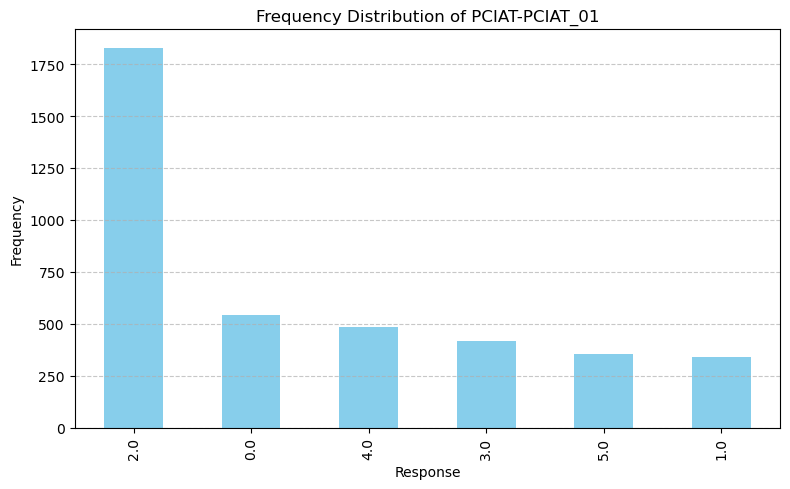

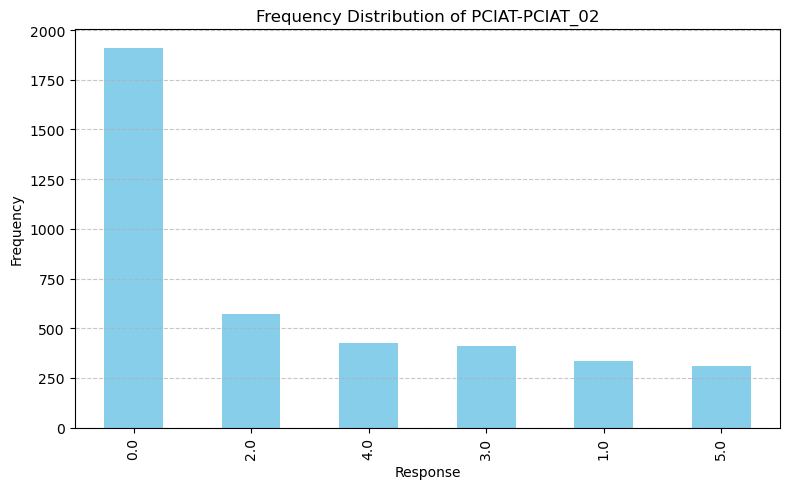

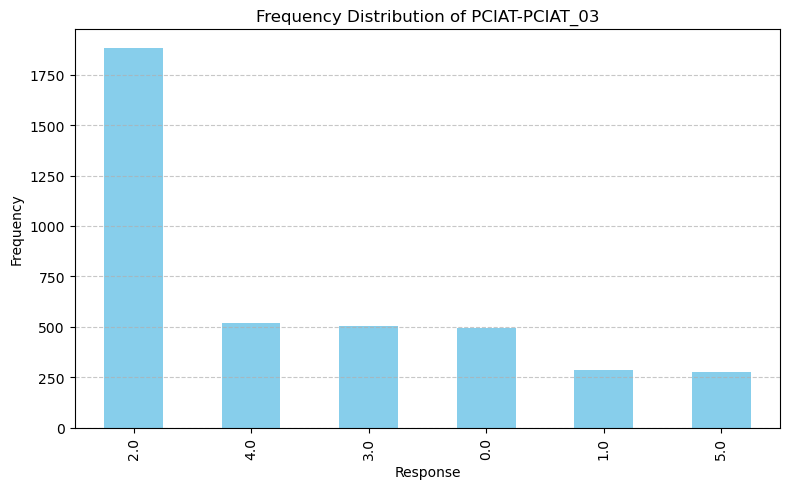

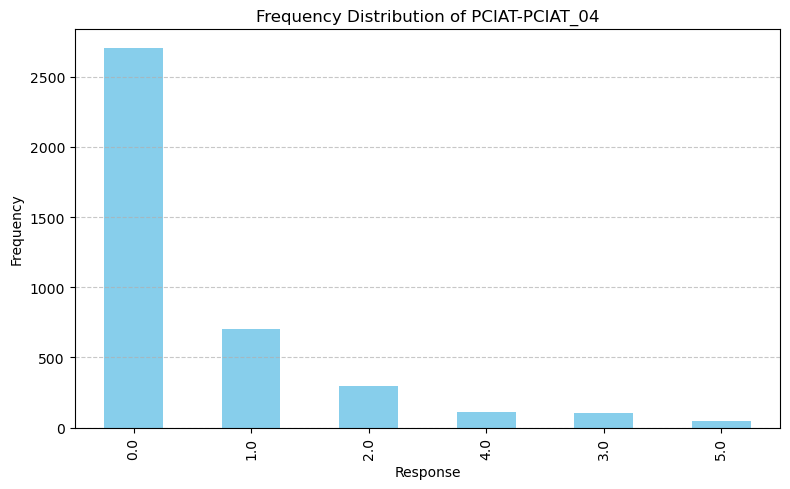

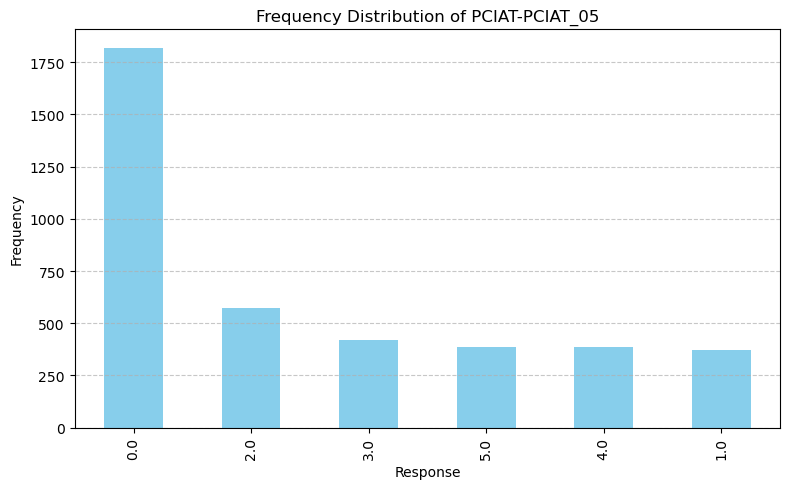

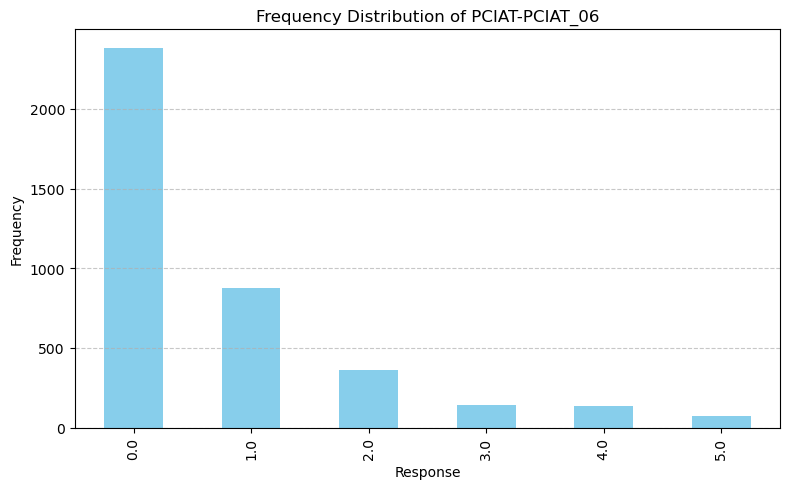

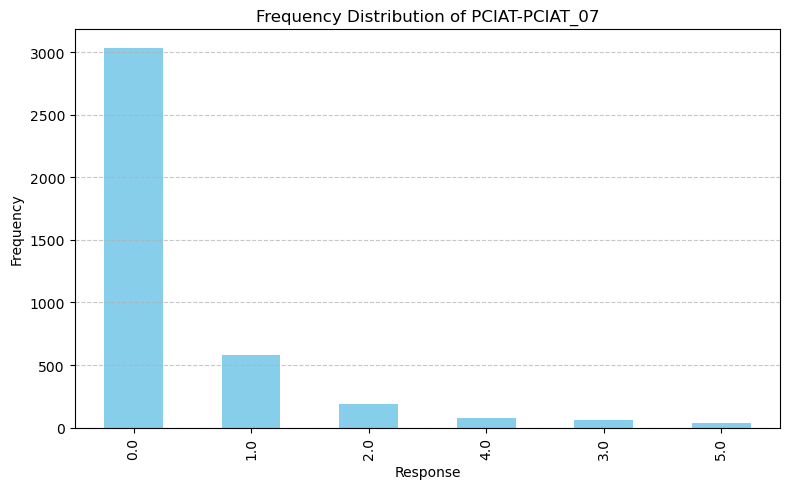

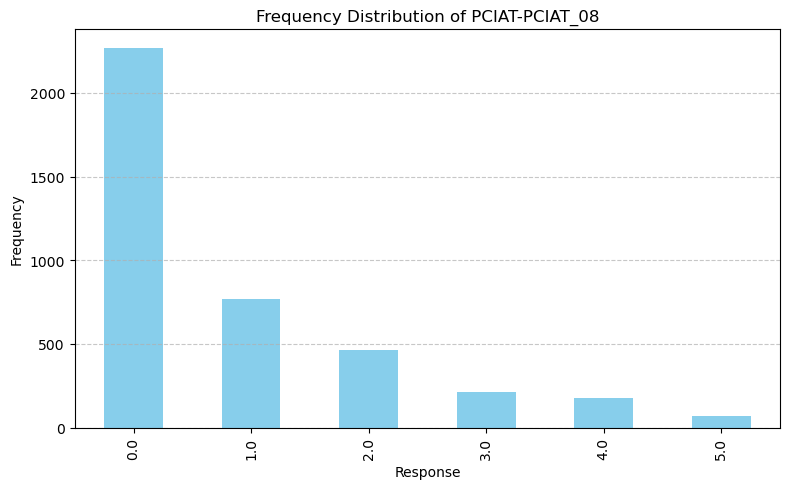

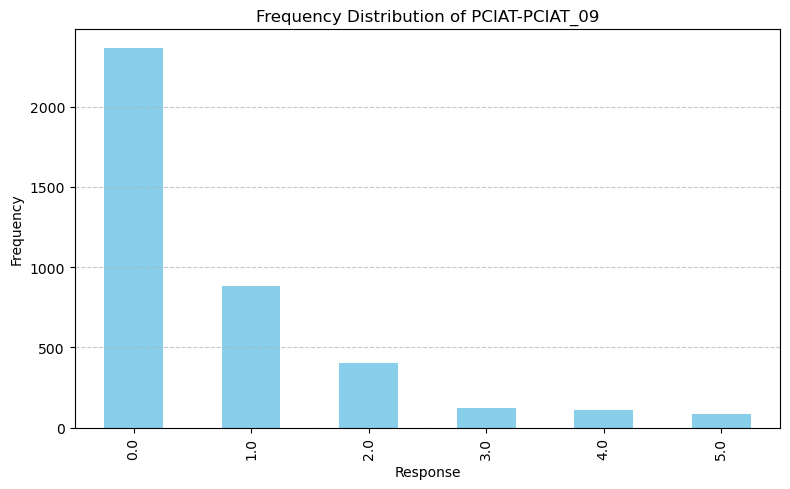

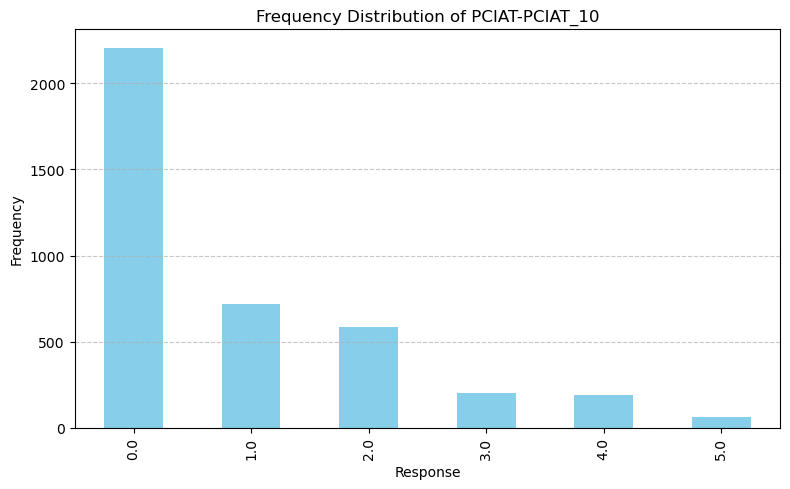

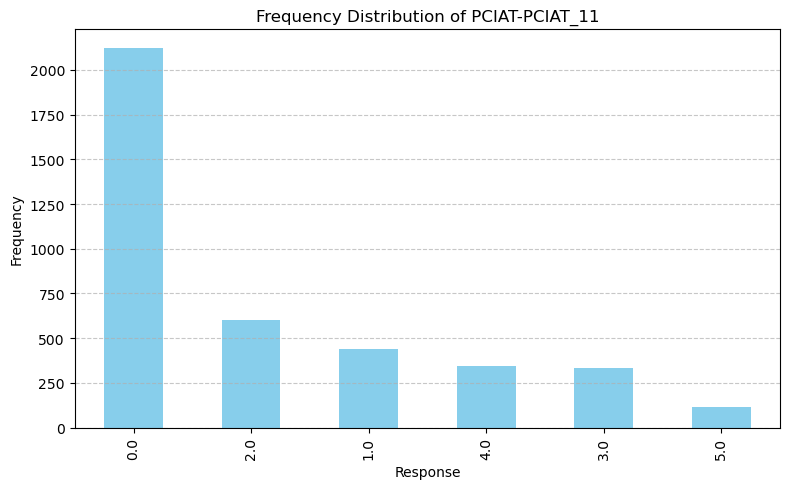

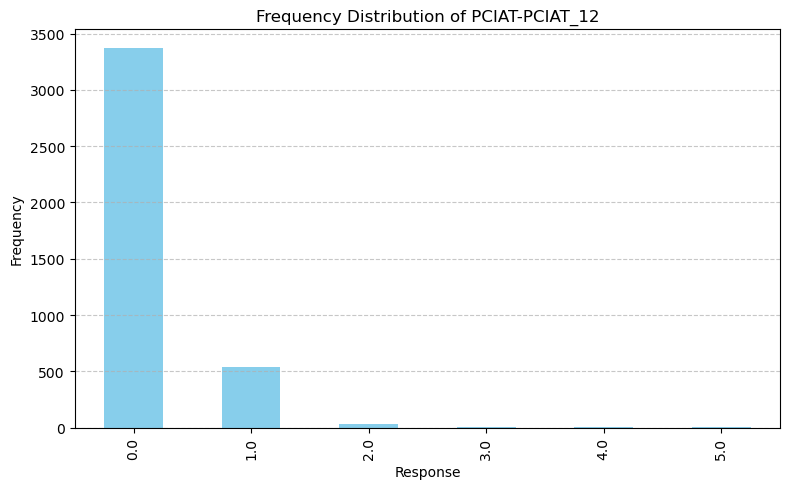

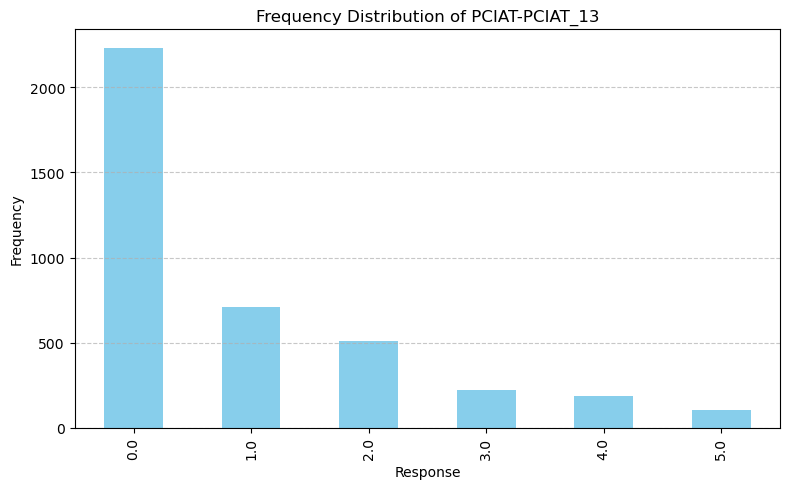

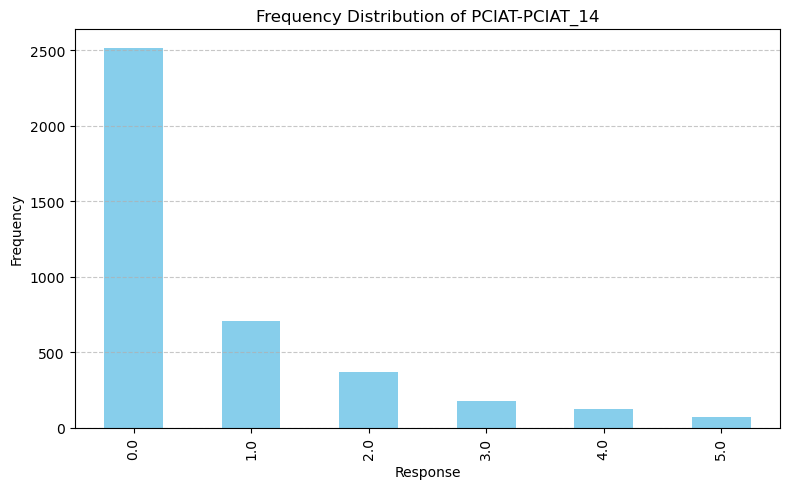

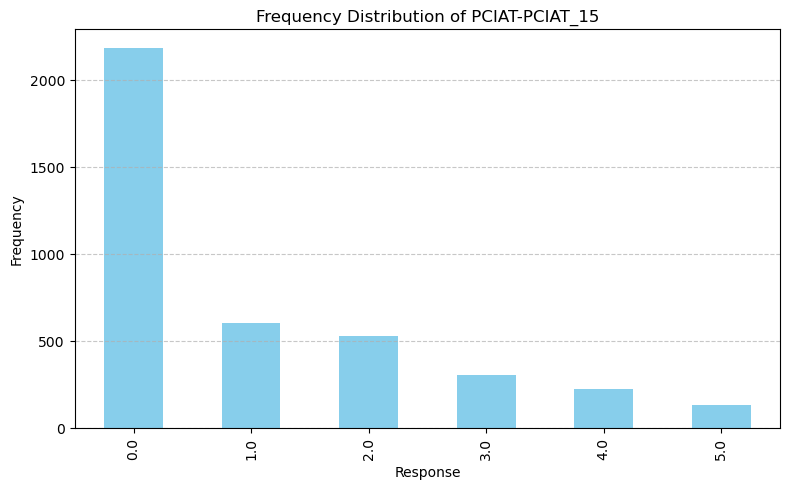

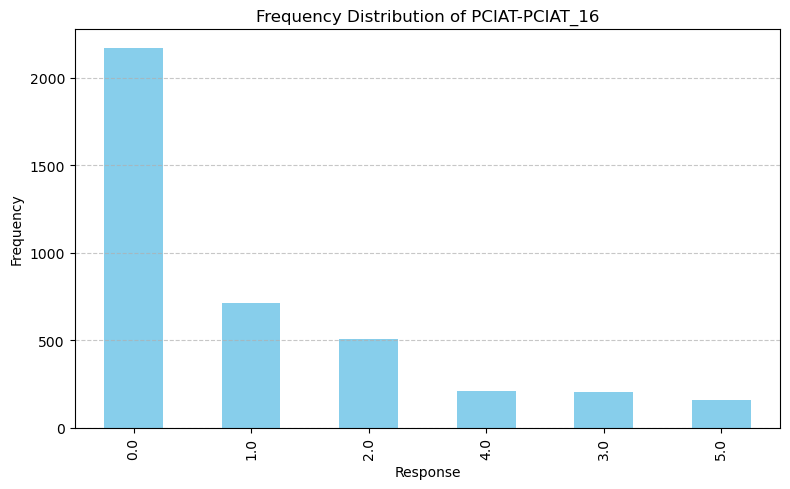

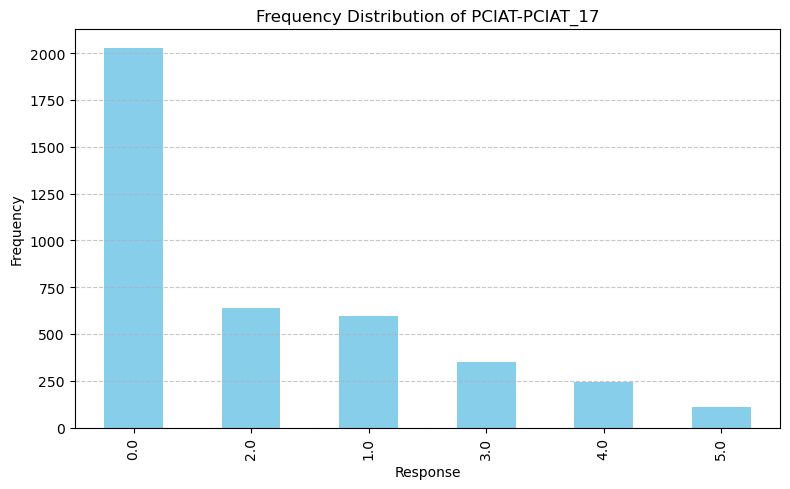

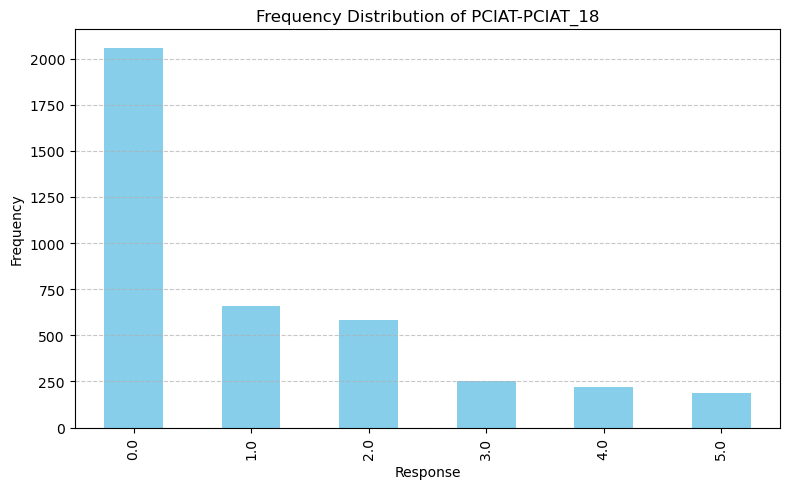

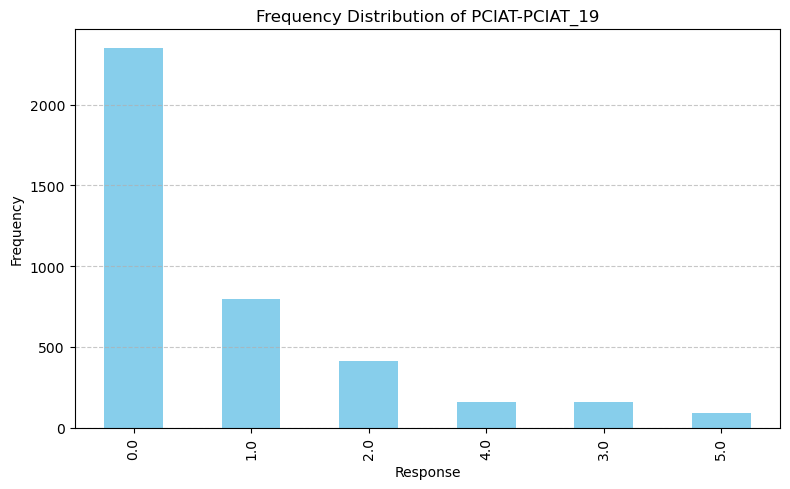

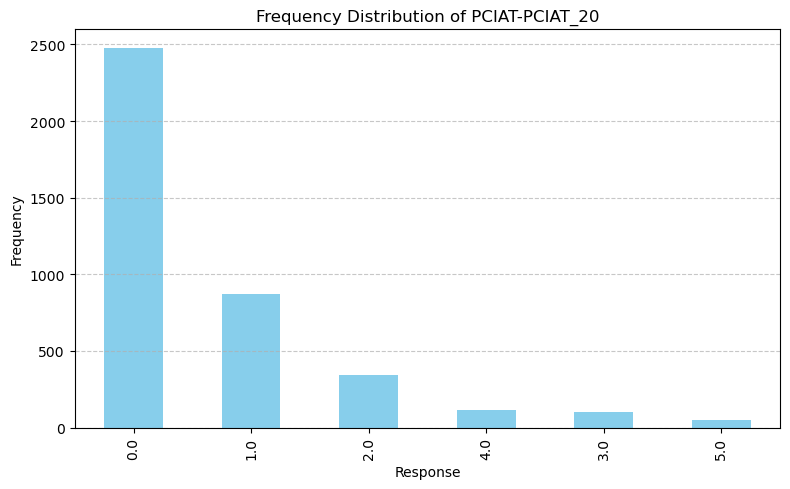

In [139]:
# Loop through all PCIAT questions
for column in pciatQ_dfCopy.columns:
    plt.figure(figsize=(8, 5)) 
    pciatQ_dfCopy[column].value_counts().plot(kind='bar', color='skyblue', title=f"Frequency of {column}")
    plt.xlabel("Response")
    plt.ylabel("Frequency")
    plt.title(f"Frequency Distribution of {column}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()  
    plt.show()

**To really understand this data, we bring in context from the data dictionary**

In [147]:
# Load in data
dd_filepath = r"C:\Users\quynh\OneDrive\Documents\DSA 330\Final Project\data_dictionary.csv"
dd = pd.read_csv(dd_filepath)

In [155]:
print(dd.head())

                           Instrument                      Field  \
0                          Identifier                         id   
1                        Demographics  Basic_Demos-Enroll_Season   
2                        Demographics            Basic_Demos-Age   
3                        Demographics            Basic_Demos-Sex   
4  Children's Global Assessment Scale                CGAS-Season   

               Description             Type                        Values  \
0         Participant's ID              str                           NaN   
1     Season of enrollment              str  Spring, Summer, Fall, Winter   
2       Age of participant            float                           NaN   
3       Sex of participant  categorical int                           0,1   
4  Season of participation              str  Spring, Summer, Fall, Winter   

       Value Labels  
0               NaN  
1               NaN  
2               NaN  
3  0=Male, 1=Female  
4               Na

In [161]:
# Filter for only PCIAT questions
pciatQ_dd = dd[dd['Field'].str.startswith('PCIAT-PCIAT_')]

for index, row in pciatQ_dd.iterrows():
    field = row['Field']  # Extract field (column name)
    description = row['Description']  # Extract description

    # Calculate mode for the corresponding field in the data
    if field in data.columns:
        mode_value = data[field].mode()[0]  # Get mode
        print(f"{field}: {description} | Mode: {mode_value}")
    else:
        print(f"{field}: {description} | Mode: Field not found in the dataset")

PCIAT-PCIAT_01: How often does your child disobey time limits you set for online use? | Mode: 2.0
PCIAT-PCIAT_02: How often does your child neglect household chores to spend more time online? | Mode: 0.0
PCIAT-PCIAT_03: How often does your child prefer to spend time online rather than with the rest of your family? | Mode: 2.0
PCIAT-PCIAT_04: How often does your child form new relationships with fellow online users? | Mode: 0.0
PCIAT-PCIAT_05: How often do you complain about the amount of time your child spends online? | Mode: 0.0
PCIAT-PCIAT_06: How often do your child's grades suffer because of the amount of time he or she spends online? | Mode: 0.0
PCIAT-PCIAT_07: How often does your child check his or her e-mail before doing something else? | Mode: 0.0
PCIAT-PCIAT_08: How often does your child seem withdrawn from others since discovering the Internet? | Mode: 0.0
PCIAT-PCIAT_09: How often does your child become defensive or secretive when asked what he or she does online? | Mode: 0.

Recall that: 0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=Frequently, 4=Often, 5=Always

## 5. Correlation Analysis

### 5a. We wish to test if Basic_Demos-Age correlates with PCIAT-PCIAT_Total

We will use the Pearson correlation test for this analysis. 

* Response: PCIAT Total 
* Predictor: Age 

**Step 1: Scatterplot**

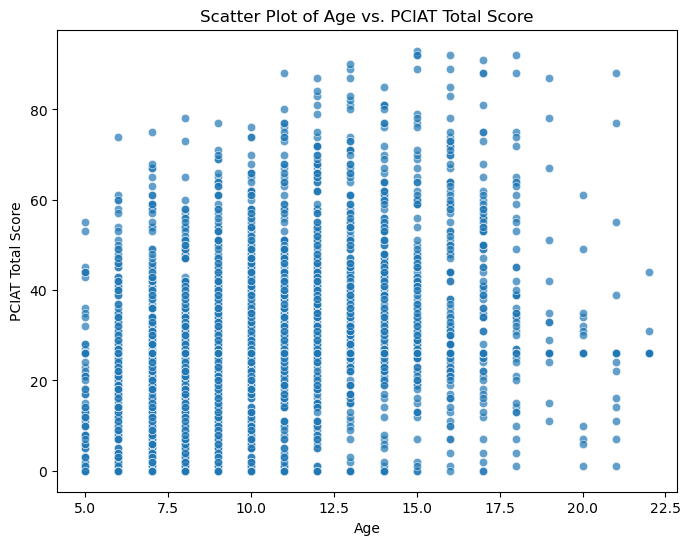

In [175]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_copy, x='Basic_Demos-Age', y='PCIAT-PCIAT_Total', alpha=0.7)
plt.title('Scatter Plot of Age vs. PCIAT Total Score')
plt.xlabel('Age')
plt.ylabel('PCIAT Total Score')
plt.show()

This looks really bad, there is practically no correlation happening, but we'll verify with a formal test 

**Step 2: Verify all assumptions to perform test**

Pearson Assumptions: 
* Both variables are on an interval or ratio level of measurement
* Data from both variables follow normal distributions
* Data has no outliers
* Data is from a random or representative sample
* Expect a linear relationship between the two variables

In [187]:
# Assumption 1: Both variables are on an interval or ratio level of measurement
print(df[['Basic_Demos-Age', 'PCIAT-PCIAT_Total']].dtypes)

Basic_Demos-Age        int64
PCIAT-PCIAT_Total    float64
dtype: object


Assumption 1 is verfied as both variables are numeric

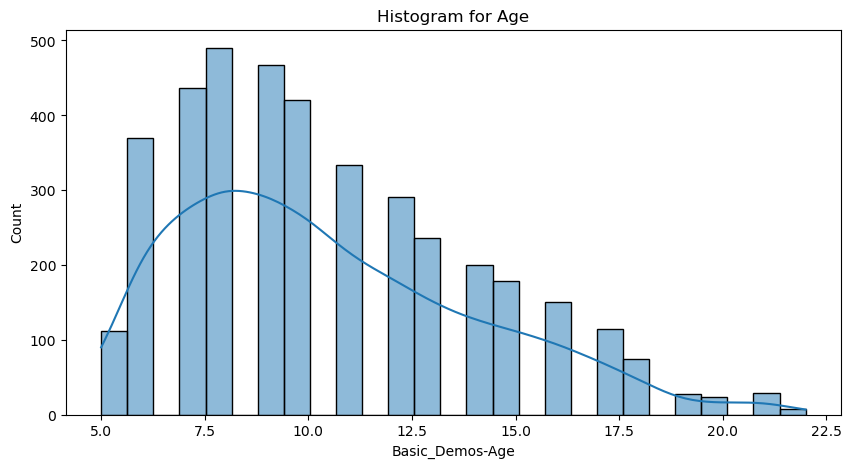

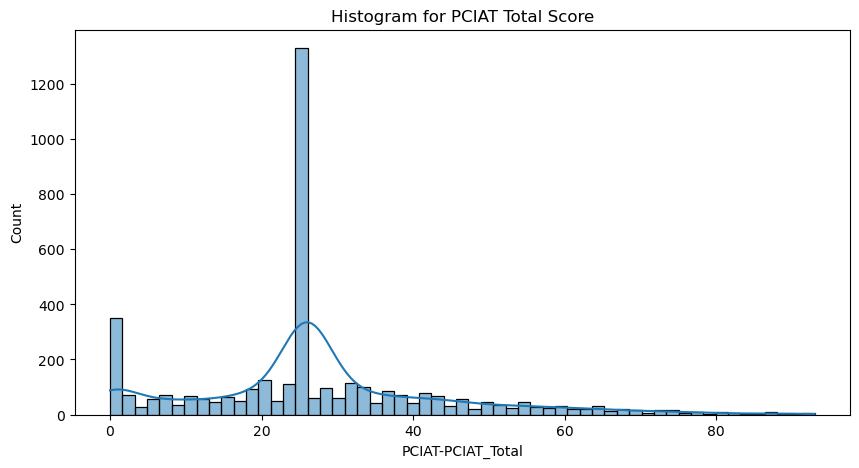

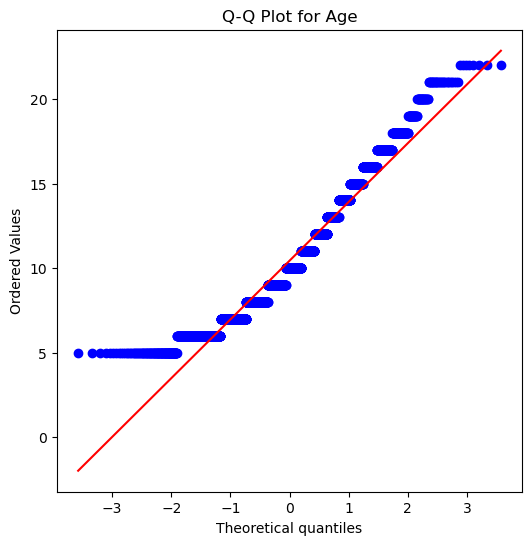

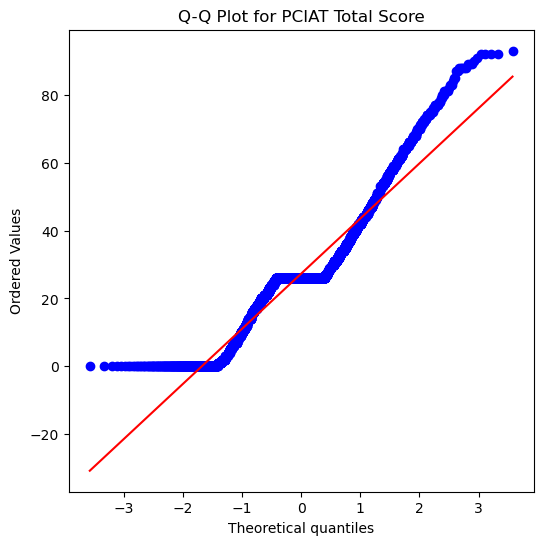

In [196]:
# Assumption 2: Data from both variables follow normal distributions
# Histogram for Age
plt.figure(figsize=(10, 5))
sns.histplot(df_copy['Basic_Demos-Age'], kde=True)
plt.title('Histogram for Age')
plt.show()

# Histogram for PCIAT Total Score
plt.figure(figsize=(10, 5))
sns.histplot(df_copy['PCIAT-PCIAT_Total'], kde=True)
plt.title('Histogram for PCIAT Total Score')
plt.show()

# Q-Q Plot for Age
plt.figure(figsize=(6, 6))
stats.probplot(df_copy['Basic_Demos-Age'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Age')
plt.show()

# Q-Q Plot for PCIAT Total Score
plt.figure(figsize=(6, 6))
stats.probplot(df_copy['PCIAT-PCIAT_Total'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for PCIAT Total Score')
plt.show()

**Age**: The histogram for age looks skewed and for the QQ plot, data points deviate from line at around 5 years old
* Data might not be normal, so we will run a formal normality test

**PCIAT Score**: The histogram for PCIAT Total looks very skewed and dense for scores close to 20-25. As for the QQ plot, data points deviate from the line. We will also run formal normality test and then normalize if needed

Assumption 2 has not been verified, so we will run the Shapiro-Wilk Test for normality for variables Age and PCIAT score

**AGE**


1. Hypotheses
* H0: The data sample is normal
* Ha: The data sample is not normal

2. We will use a 95% Confidence, alpha = 0.05

In [212]:
# Shapiro-Wilk Test for Age
stat, p = shapiro(df_copy['Basic_Demos-Age'].dropna())
print(f"Shapiro-Wilk Test for Age: Statistic={stat}, p-value={p}")

Shapiro-Wilk Test for Age: Statistic=0.9440175171493267, p-value=2.3616253980673225e-36


**AGE**: The p-value is extremely small and less than alpha, we reject the null hypothesis. The data is not normal

**PCIAT TOTAL**

1. Hypotheses
* H0: The data sample is normal
* Ha: The data sample is not normal

2. We will use a 95% Confidence, alpha = 0.05

In [214]:
# Shapiro-Wilk Test for PCIAT Total Score
stat, p = shapiro(df_copy['PCIAT-PCIAT_Total'].dropna())
print(f"Shapiro-Wilk Test for PCIAT Total Score: Statistic={stat}, p-value={p}")

Shapiro-Wilk Test for PCIAT Total Score: Statistic=0.9191068558523253, p-value=8.364435414635004e-42


**PCIAT-PCIAT_Total**: The p-value is extremely small and less than alpha, we reject the null hypothesis. The data is not normal

We cannot use the Pearson correlation test as both samples failed assumption number 2. We either normalize the data or switch to a test that does not require normal data

Let's try Spearman's Rank Test as it does not require normality